In [20]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from keras.datasets import fashion_mnist
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook 

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [22]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [49]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
   # x = np.float128(x)
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
       
     
        
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                 
      m = X.shape[1]
    
      for i in range(self.nh+1):
        
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float))
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

In [48]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
train_data = np.array(X_train)
X_train = train_data / 255.0
test_data = np.array(X_test)
X_test = test_data / 255.0
print(train_data.shape)
print(test_data.shape)


#One hot encoding of the class labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.expand_dims(Y_train,1)).toarray()

y_test = encoder.fit_transform(np.expand_dims(Y_test,1)).toarray()

(60000, 28, 28)
(10000, 28, 28)


C:\Users\susmi\AppData\Local\Temp\ipykernel_1648\997872746.py:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/50 [00:00<?, ?epoch/s]

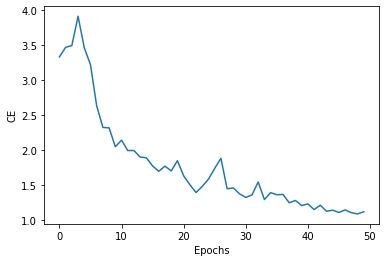

In [46]:
ffsnn = FFSN_MultiClass(784,10, [32,32,32])
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
#OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()

ffsnn.fit(X_train, y_train, epochs=50, learning_rate=.001, display_loss=True)

In [47]:
Y_pred_train = ffsnn.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ffsnn.predict(X_test)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val, Y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.59
Validation accuracy 0.59


In [18]:
past_value_w = np.copy(dW[i+1])
past_value_b = np.copy(dB[i+1])
past_value_w.fill(0)
past_value_b.fill(0)
temp_w = self.W[i+1] - gamma * past_value_w
self.W[i+1] = temp-w - learning_rate * (dW[i+1]/m)
past_value_w = gamma * past_value_w + learning_rate *  

[0. 0. 0. 0.]
[2. 2. 2. 2.]


In [8]:
import numpy as np
a = np.array([[1,4,9],[25,36,49]])
epsilon = 1
print(a ** 0.5 + epsilon)

[[2. 3. 4.]
 [6. 7. 8.]]


In [16]:
a = [1,2,3,4]
b =a + [4]
print(b)

[1, 2, 3, 4, 4]
